In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(0,"../")

In [2]:
import matplotsoccer as mps
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
data = "../data/spadl-v2.hdf"
games = pd.read_hdf(data,key="games")
epl16 = games[(games.competition_id == 8) & (games.season_id == 2016)]
epl16[:5]

/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,id,game_date,competition_id,season_id,home_team_id,away_team_id,duration
0,855383,2017-01-22 14:15:00,8,2016,3,90,99
0,855500,2017-04-15 14:00:00,8,2016,57,80,95
0,855485,2017-04-08 14:00:00,8,2016,43,88,94
0,855291,2016-11-21 20:00:00,8,2016,35,90,94
0,855213,2016-09-18 13:15:00,8,2016,31,110,94


In [4]:
def get_actions(games, hdf_url):
    actions = []
    for game in tqdm(list(games.itertuples())):
        a = pd.read_hdf(hdf_url, key="actions/" + str(game.id))
        a["left_to_right"] = a["team_id"] == game.home_team_id
        actions.append(a)
    actions = pd.concat(actions)

    #actions = always_ltr(actions)
    return actions


def always_ltr(actions):
    away_idx = ~actions.left_to_right
    actions.loc[away_idx, "start_x"] = 105 - actions[away_idx].start_x.values
    actions.loc[away_idx, "start_y"] = 68 - actions[away_idx].start_y.values
    actions.loc[away_idx, "end_x"] = 105 - actions[away_idx].end_x.values
    actions.loc[away_idx, "end_y"] = 68 - actions[away_idx].end_y.values
    return actions

actions = get_actions(epl16,data)

actiontypes = pd.read_hdf(data, key="actiontypes")
actiontypes.columns = ["type_id","type_name"]
actions = actions.merge(actiontypes, on="type_id")

players = pd.read_hdf(data,key="players")
actions = actions.merge(players,left_on="player_id",right_on="id")

teams = pd.read_hdf(data,key="teams")
actions = actions.merge(teams,left_on="team_id",right_on="id")

actions.columns

100%|██████████| 380/380 [00:08<00:00, 56.77it/s]


Index(['game_id', 'period_id', 'time_seconds', 'timestamp', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'bodypart',
       'type_id', 'result', 'left_to_right', 'type_name', 'id_x', 'first_name',
       'last_name', 'soccer_name', 'birthday', 'nation_id', 'id_y',
       'full_name', 'short_name', 'abbreviation'],
      dtype='object')

In [5]:
actions = actions.sort_values(["game_id","period_id","time_seconds","timestamp"])

In [6]:
start = 499604
delta = 13
a = actions[start:start+delta].copy()

/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


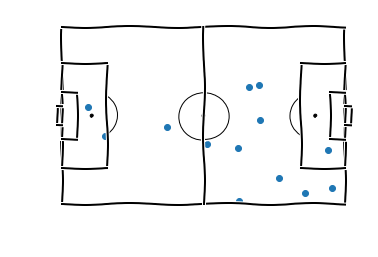

In [7]:
with plt.xkcd():
    ax = mps.field(show=False)
    ax.scatter(a.start_x,a.start_y)
    plt.show()

ValueError: all the input arrays must have same number of dimensions

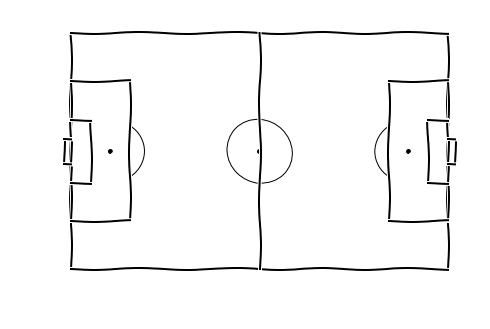

In [8]:
f = lambda: mps.actions(a[["start_x","start_y"]],a.type_name,figsize=8)
with plt.xkcd():
    f()
f()

[['keeper_claim']
 ['pass']
 ['pass']
 ['pass']
 ['pass']
 ['dribble']
 ['pass']
 ['pass']
 ['dribble']
 ['pass']
 ['pass']
 ['dribble']
 ['pass']]


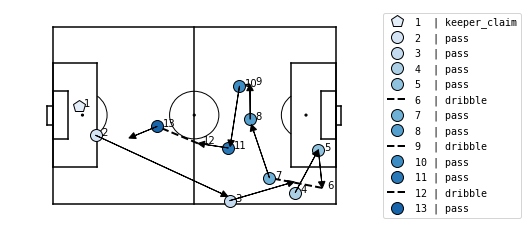

In [14]:
mps.actions(a[["start_x","start_y","end_x","end_y"]],a.type_name)

<IPython.core.display.Javascript object>


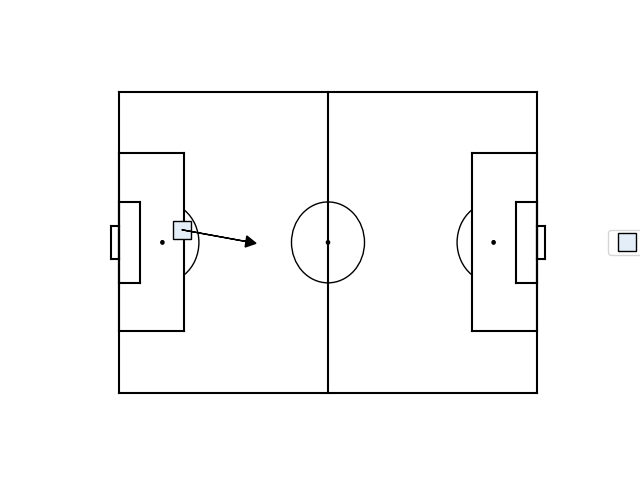

In [162]:
%matplotlib notebook

start = 499604
delta = 110
b = actions[start:start+delta].copy()

fig = plt.figure()
viewer = fig.add_subplot(111)
plt.ion() # Turns interactive mode on (probably unnecessary)
fig.show() 

nb = 10

for i in range(0,delta):
    a = b[i:i+nb]
    viewer.clear() # Clears the previous image
    mps.actions(a[["start_x","start_y","end_x","end_y"]],a.type_name,ax=viewer)
    plt.pause(.1) # Delay in seconds
    fig.canvas.draw()

In [ ]:
x = [] # Some array of images
fig = plt.figure()
viewer = fig.add_subplot(111)
plt.ion() # Turns interactive mode on (probably unnecessary)
fig.show() # Initially shows the figure

for i in range(len(x)):
    viewer.clear() # Clears the previous image
    viewer.imshow(x[i]) # Loads the new image
    plt.pause(.1) # Delay in seconds
    fig.canvas.draw()

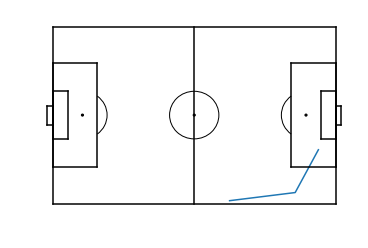

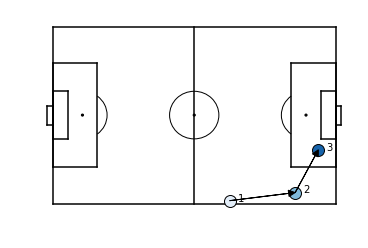

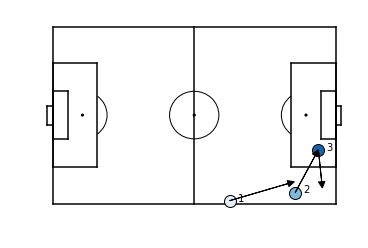

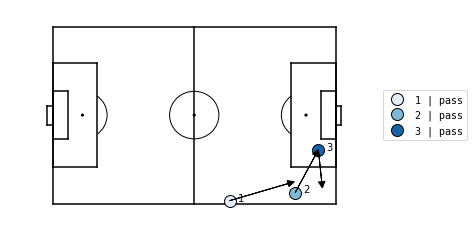

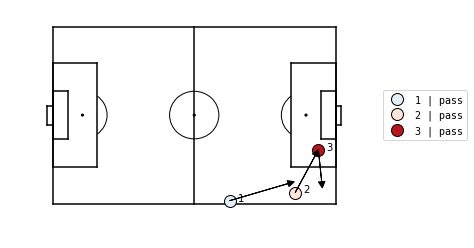

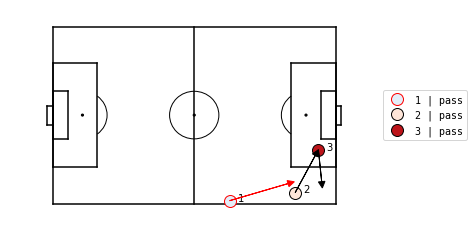

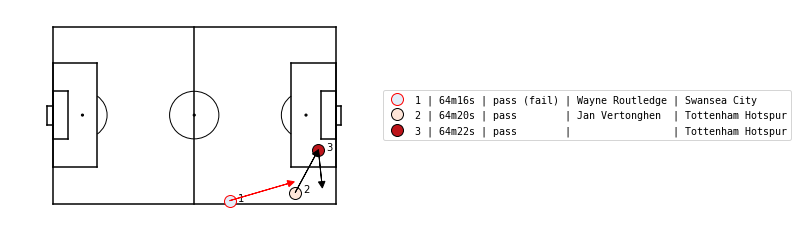

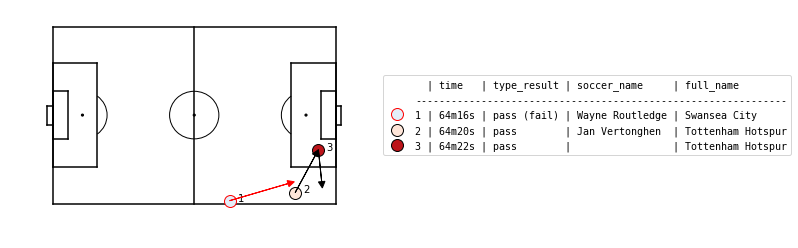

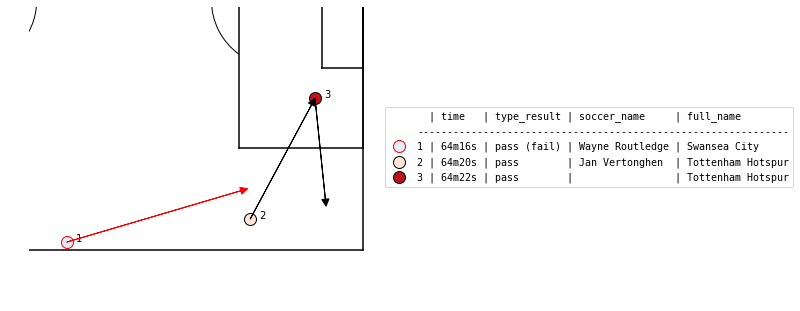

In [27]:
start = 499606
delta = 3
a = actions[start:start+delta].copy()
ax = mps.field(show=False)
ax.plot(a.start_x,a.start_y)
plt.show()


def time(action):
    return "%sm%ss" % (int(action.time_seconds) // 60, int(action.time_seconds) % 60)

def action_type(action):
    return action.type_name if action.result else action.type_name + " (fail)"

a["time"] = a.apply(time,axis=1)
a["type_result"] = a.apply(action_type,axis=1)
labels = a[["time","type_result","soccer_name","full_name"]]

mps.actions(a[["start_x","start_y"]])
mps.actions(a[["start_x","start_y","end_x","end_y"]])
mps.actions(a[["start_x","start_y","end_x","end_y"]],a.type_name)
mps.actions(a[["start_x","start_y","end_x","end_y"]],a.type_name, team=a.team_id)
mps.actions(a[["start_x","start_y","end_x","end_y"]],a.type_name, team=a.team_id,result=a.result)
mps.actions(a[["start_x","start_y","end_x","end_y"]],a.type_name, team=a.team_id,result=a.result,label=labels)
mps.actions(a[["start_x","start_y","end_x","end_y"]],a.type_name,
            team=a.team_id,result=a.result,label=labels,labeltitle = labels.columns)
mps.actions(a[["start_x","start_y","end_x","end_y"]],a.type_name,
            team=a.team_id,result=a.result,label=labels,labeltitle = labels.columns,zoom=True)

In [118]:
np.asarray(["team x" for i in range(5)]).ndim

1

In [29]:
open('../README.md').read()

'# README #\n\nSoccer, yay!\n\nwork-in-progress package to visualize soccer data\n\nThe most important functions are:\n\n```\nmatplotsoccer.field # create a soccerfield with matplotlib\nmatplotsoccer.heatmap # create a heatmap over a soccerfield\nmatplotsoccer.actions # Visualise event stream data\n```'

[['Liverpool', 'Nathaniel Clyne', '5251.0'], ['Liverpool', 'Joel Matip', '5252.0'], ['Liverpool', 'Loris Karius', '5253.0'], ['Sunderland', 'Patrick van Aanholt', '5277.0'], ['Liverpool', '', '5280.0'], ['Liverpool', '', '5280.5'], ['Liverpool', '', '5281.0'], ['Liverpool', 'Nathaniel Clyne', '5282.0'], ['Liverpool', 'Jordan Henderson', '5283.0'], ['Liverpool', 'Divock Origi', '5287.0']]


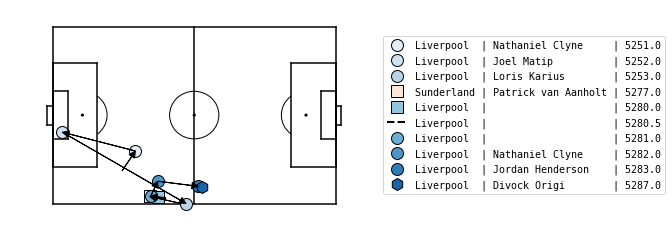

In [27]:
#locations = a.start_x,a.start_y,a.end_x,a.end_y
actions2(a.type_name,locations,teams=a.team,labels = a[["team","player","time_seconds"]])
#a.values.tolist()

In [54]:
import numpy as np

b = np.asarray(a)
for i in b:
    print(b)
#zip(*[times,type_names,players,a.team]))

[['Liverpool' 'Nathaniel Clyne' 5251.0 'pass' 1 25.724999999999998 12.58
  30.659999999999997 20.195999999999998]
 ['Liverpool' 'Joel Matip' 5252.0 'pass' 1 30.659999999999997
  20.195999999999998 3.5700000000000003 27.403999999999996]
 ['Liverpool' 'Loris Karius' 5253.0 'pass' 0 3.5700000000000003
  27.403999999999996 49.455000000000005 0.0]
 ['Sunderland' 'Patrick van Aanholt' 5277.0 'throw_in' 1
  47.669999999999995 0.0 35.91000000000001 2.719999999999999]
 ['Liverpool' '' 5280.0 'tackle' 1 39.165 2.3120000000000003 39.165
  2.3120000000000003]
 ['Liverpool' '' 5280.5 'dribble' 1 39.165 2.3120000000000003 42.0 2.108]
 ['Liverpool' '' 5281.0 'pass' 1 42.0 2.108 36.330000000000005 2.788]
 ['Liverpool' 'Nathaniel Clyne' 5282.0 'pass' 1 36.330000000000005 2.788
  38.955 8.568]
 ['Liverpool' 'Jordan Henderson' 5283.0 'pass' 0 38.955 8.568 54.075
  6.595999999999999]
 ['Liverpool' 'Divock Origi' 5287.0 'foul' 1 55.230000000000004
  6.324000000000001 55.230000000000004 6.324000000000001]]


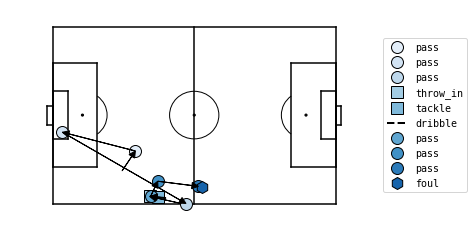

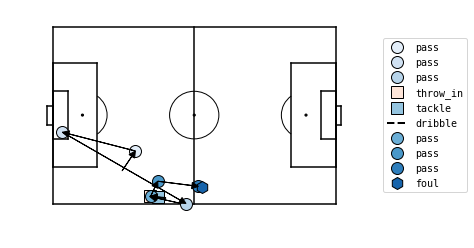

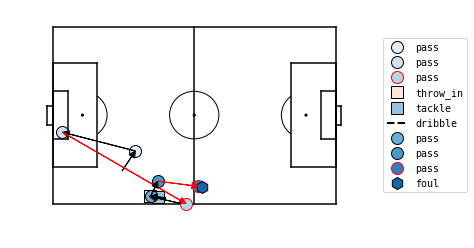

['Liverpool' 'Nathaniel Clyne' 5251.0 'pass' 1 25.724999999999998 12.58
 30.659999999999997 20.195999999999998]
['Liverpool' 'Joel Matip' 5252.0 'pass' 1 30.659999999999997
 20.195999999999998 3.5700000000000003 27.403999999999996]
['Liverpool' 'Loris Karius' 5253.0 'pass' 0 3.5700000000000003
 27.403999999999996 49.455000000000005 0.0]
['Sunderland' 'Patrick van Aanholt' 5277.0 'throw_in' 1 47.669999999999995
 0.0 35.91000000000001 2.719999999999999]
['Liverpool' '' 5280.0 'tackle' 1 39.165 2.3120000000000003 39.165
 2.3120000000000003]
['Liverpool' '' 5280.5 'dribble' 1 39.165 2.3120000000000003 42.0 2.108]
['Liverpool' '' 5281.0 'pass' 1 42.0 2.108 36.330000000000005 2.788]
['Liverpool' 'Nathaniel Clyne' 5282.0 'pass' 1 36.330000000000005 2.788
 38.955 8.568]
['Liverpool' 'Jordan Henderson' 5283.0 'pass' 0 38.955 8.568 54.075
 6.595999999999999]
['Liverpool' 'Divock Origi' 5287.0 'foul' 1 55.230000000000004
 6.324000000000001 55.230000000000004 6.324000000000001]


In [63]:
actions2(a.type_name,locations)
actions2(a.type_name,locations,teams=a.team)
actions2(a.type_name,locations,teams=a.team,results=a.result)

type_names = [
        action.type_name if action.result else action.type_name + " (fail)"
        for action in a.itertuples()
    ]
players = a.player
times = ["%sm%ss" % (int(action.time_seconds) // 60, int(action.time_seconds) % 60)
        for action in a.itertuples()]
labels = [times,type_names,players,a.team]
#actions2(a.type_name,locations,teams=a.team,results=a.result,labels=labels)
for i in np.asarray(a):
    print(i)

In [106]:
np.asarray(None)

m = np.array([[1,2,3],[4,5,6]]).reshape(-1,2)
newm = m.copy()
newm[:-1,:] = newm[1:,:]
m = np.concatenate([m,newm],axis=1)
m

array([[1, 2, 3, 4],
       [3, 4, 5, 6],
       [5, 6, 5, 6]])